In [20]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import json
import re
from pathlib import Path
from typing import Dict, List, Tuple, Optional

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, balanced_accuracy_score
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors

# 0. Data preparation

### 1. Text data preparation

In [21]:
# loader 

def load_jobs_json(
    json_path: str,
    job_id_col_candidates: Tuple[str, ...] = ("job_id", "id"),
    text_col_candidates: Tuple[str, ...] = ("description", "text", "job_text", "title", "name"),
    max_rows: Optional[int] = None,
) -> pd.DataFrame:
    """
    Loads a job offers JSON file.
    Supports:
      - JSON Lines: one json per line
      - JSON array: [ {...}, {...} ]
      - JSON dict with a list field: {"jobs": [ ... ]} (best-effort)
    Returns a DataFrame with at least columns: job_id, job_text_raw
    """
    path = Path(json_path)
    if not path.exists():
        raise FileNotFoundError(f"File not found: {json_path}")

    # Try JSON lines first
    try:
        df = pd.read_json(path, lines=True)
        if max_rows is not None:
            df = df.head(max_rows)
    except ValueError:
        # Fallback: classic JSON
        with open(path, "r", encoding="utf-8") as f:
            obj = json.load(f)

        if isinstance(obj, list):
            df = pd.DataFrame(obj)
        elif isinstance(obj, dict):
            # try to find the first list-like field
            list_field = None
            for k, v in obj.items():
                if isinstance(v, list):
                    list_field = k
                    break
            if list_field is None:
                raise ValueError("Unsupported JSON dict structure: no list field found.")
            df = pd.DataFrame(obj[list_field])
        else:
            raise ValueError("Unsupported JSON structure (expected list or dict).")

        if max_rows is not None:
            df = df.head(max_rows)

    # Resolve job_id col
    job_id_col = next((c for c in job_id_col_candidates if c in df.columns), None)
    if job_id_col is None:
        raise ValueError(f"No job id column found among: {job_id_col_candidates}. Columns: {df.columns.tolist()}")

    # Resolve text col (best effort)
    text_col = next((c for c in text_col_candidates if c in df.columns), None)
    if text_col is None:
        raise ValueError(f"No text column found among: {text_col_candidates}. Columns: {df.columns.tolist()}")

    out = df[[job_id_col, text_col]].copy()
    out.columns = ["job_id", "job_text_raw"]
    out["job_id"] = out["job_id"].astype(int, errors="ignore")
    out["job_text"] = out["job_text_raw"].map(clean_text)
    out = out.drop_duplicates("job_id").reset_index(drop=True)
    return out[["job_id", "job_text"]]


In [22]:
import pandas as pd

df_debug = pd.read_json("/Users/enfants/Code/Job Offer Recommendation/job_listings.json", lines=True)
print(df_debug.columns)
df_debug.head()



Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       27359, 27360, 27361, 27362, 27363, 27364, 27365, 27366, 27367, 27368],
      dtype='int64', length=21917)


,0,1,2,3,4,5,6,7,8,9,...,27359,27360,27361,27362,27363,27364,27365,27366,27367,27368
0,TITLE\nQA Intégration / Data Analyst - SalesF...,TITLE\nIngénieur Système\n\nSUMMARY\nNous re...,TITLE\nTesteur QA Automatisation Cypress\n\nSU...,TITLE\nIngénieur support N3 IP - PARIS \n\nSU...,TITLE\nBusiness Analyst MOA FRONT\n\nSUMMARY\n...,TITLE\nBusiness Analyst SAP S/4\n\nSUMMARY\nNo...,TITLE\nSalesforce Marketing Cloud Product Owne...,TITLE\nResponsable Sécurité Opérationnel \n...,TITLE\nArchitecte d'entreprise Data BI\n\nSUMM...,TITLE\nIngénieur.e QA web / mobile - (Haute-S...,...,TITLE\nParis-Administrateur Système DB2 - Z/O...,TITLE\nIngénieur d’intégration applicative\n...,"TITLE\nConsultant MS BI Confirmé Build & Run,...",TITLE\nData modeler / Senior\n\nSUMMARY\nNous ...,TITLE\nLyon-Développeur Cobol Mainframe-R2030...,TITLE\nIncident Manager e-commerce\n\nSUMMARY\...,TITLE\nConsultant Azure Security\n\nSUMMARY\nK...,TITLE\nChef de projet Supply Chain\n\nSUMMARY\...,TITLE\nPO Infrastructure\n\nSUMMARY\nUn Produc...,"TITLE\nData Engineer Senior Spark, Scala, Data..."


In [23]:
JOBS_JSON_PATH = "/Users/enfants/Code/Job Offer Recommendation/job_listings.json"

with open(JOBS_JSON_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

print(type(data))
print(len(data))

<class 'dict'>
21917


In [24]:
jobs_df = pd.DataFrame({
    "job_id": list(data.keys()),
    "job_text_raw": list(data.values())
})

jobs_df["job_id"] = jobs_df["job_id"].astype(int)

jobs_df.head()

,job_id,job_text_raw
0,0,TITLE\nQA Intégration / Data Analyst - SalesF...
1,1,TITLE\nIngénieur Système\n\nSUMMARY\nNous re...
2,2,TITLE\nTesteur QA Automatisation Cypress\n\nSU...
3,3,TITLE\nIngénieur support N3 IP - PARIS \n\nSU...
4,4,TITLE\nBusiness Analyst MOA FRONT\n\nSUMMARY\n...


In [25]:
jobs_df["job_text"] = jobs_df["job_text_raw"].map(clean_text)
jobs_df = jobs_df[["job_id", "job_text"]]

print(jobs_df.shape)
jobs_df.head()

(21917, 2)


,job_id,job_text
0,0,title qa inte gration / data analyst - salesfo...
1,1,title inge nieur syste me summary nous recherc...
2,2,title testeur qa automatisation cypress summar...
3,3,title inge nieur support n3 ip - paris summary...
4,4,title business analyst moa front summary nous ...


In [64]:
print("Jobs texte:", jobs_df["job_id"].nunique())
print("Jobs Markov from_job:", trans_df["from_job"].nunique())
print("Jobs Markov to_job:", trans_df["to_job"].nunique())


Jobs texte: 21917
Jobs Markov from_job: 20505
Jobs Markov to_job: 20366


In [65]:
print("Empty texts:", (jobs_df["job_text"].str.len() == 0).sum())

Empty texts: 0


In [66]:
job_id_to_text: Dict[int, str] = dict(zip(jobs_df["job_id"].tolist(), jobs_df["job_text"].tolist()))

### 2. Text Representation (TF-IDF → vector by job_id)

In [85]:
def build_tfidf(
    jobs_df: pd.DataFrame,
    min_df: int = 3,
    max_features: int = None,
    ngram_range: Tuple[int, int] = (1, 2),
) -> Tuple[TfidfVectorizer, np.ndarray, List[int]]:
    """
    Returns:
      - fitted vectorizer
      - tfidf_matrix (sparse)
      - job_ids aligned with matrix rows
    """
    job_ids = jobs_df["job_id"].astype(int).tolist()
    texts = jobs_df["job_text"].fillna("").tolist()

    vectorizer = TfidfVectorizer(
        min_df=min_df,
        max_features=max_features,
        ngram_range=ngram_range,
        strip_accents="unicode",
    )
    tfidf_matrix = vectorizer.fit_transform(texts)
    return vectorizer, tfidf_matrix, job_ids


vectorizer, tfidf_matrix, tfidf_job_ids = build_tfidf(jobs_df)
print(tfidf_matrix.shape)


(21917, 225487)


In [87]:
def build_text_neighbors(
    tfidf_matrix,
    job_ids: List[int],
    top_n: int = 50,
    n_jobs: int = -1
) -> Dict[int, List[Tuple[int, float]]]:
    """
    Returns mapping:
      job_id -> [(neighbor_job_id, similarity), ...] sorted by similarity desc
    """
    nn = NearestNeighbors(
        n_neighbors=top_n + 1,  # +1 because the closest is itself
        metric="cosine",
        algorithm="brute",
        n_jobs=n_jobs
    )
    nn.fit(tfidf_matrix)

    distances, indices = nn.kneighbors(tfidf_matrix, return_distance=True)

    id_by_row = np.array(job_ids)
    neighbors_map: Dict[int, List[Tuple[int, float]]] = {}

    for row_idx in range(indices.shape[0]):
        src_job_id = int(id_by_row[row_idx])
        row_neighbors = []
        for d, j in zip(distances[row_idx], indices[row_idx]):
            neighbor_job_id = int(id_by_row[j])
            if neighbor_job_id == src_job_id:
                continue
            sim = float(1.0 - d)  # cosine distance -> similarity
            row_neighbors.append((neighbor_job_id, sim))
        neighbors_map[src_job_id] = row_neighbors[:top_n]

    return neighbors_map

In [86]:
text_neighbors = build_text_neighbors(tfidf_matrix, tfidf_job_ids, top_n=50)
# exemple
next(iter(text_neighbors.items()))

(0,
 [(106, 0.4667667696578309),
  (3509, 0.3612873565758661),
  (10050, 0.3367189717529556),
  (9390, 0.31528158657937067),
  (9874, 0.3142630084111392),
  (5677, 0.30727040814093076),
  (14312, 0.30456451216518343),
  (11915, 0.3032515282328414),
  (4276, 0.3024808048108716),
  (2792, 0.2983873386317648),
  (4840, 0.2949556365659036),
  (11852, 0.2902971037960578),
  (8110, 0.28603617369945256),
  (332, 0.28600699797583595),
  (3277, 0.2782898981808005),
  (2945, 0.2780683272356689),
  (3871, 0.27391672494955166),
  (15571, 0.27304637423259415),
  (5988, 0.27216440562050326),
  (11333, 0.2716968438542422),
  (5794, 0.2713767754475159),
  (6815, 0.26838542852362945),
  (125, 0.26546122141278405),
  (7971, 0.26515861215551806),
  (2911, 0.26420682815510754),
  (4324, 0.261622917608643),
  (6186, 0.26145768444266737),
  (13930, 0.26133949018969604),
  (11526, 0.2612461518352849),
  (5918, 0.2603381713971833),
  (1607, 0.2603290918904202),
  (8440, 0.2597818668230224),
  (8817, 0.2594580

In [101]:
text_neighbors[100][:5]


[(5435, 0.3481510048171933),
 (98, 0.3257228466758386),
 (5498, 0.3255268377533034),
 (2105, 0.3062507793305588),
 (22550, 0.3015881810036656)]

In [88]:
def build_job_popularity(train_df: pd.DataFrame, seq_col: str = "full_job_sequence") -> Dict[int, float]:
    counts = {}
    for seq in train_df[seq_col]:
        for job_id in seq:
            counts[job_id] = counts.get(job_id, 0) + 1

    total = sum(counts.values()) if counts else 1
    popularity = {job_id: c / total for job_id, c in counts.items()}
    return popularity

In [89]:
job_popularity = build_job_popularity(train_df)

In [90]:
def build_markov_map(trans_df: pd.DataFrame, top_n: int = 50) -> Dict[int, List[Tuple[int, float]]]:
    trans_df_sorted = trans_df.sort_values(["from_job", "prob"], ascending=[True, False])
    markov_map = {}
    for from_job, group in trans_df_sorted.groupby("from_job"):
        top = group.head(top_n)[["to_job", "prob"]].values.tolist()
        markov_map[int(from_job)] = [(int(j), float(p)) for j, p in top]
    return markov_map

In [91]:
def recommend_jobs(
    session_job_ids: List[int],
    markov_map: Dict[int, List[Tuple[int, float]]],
    text_neighbors: Dict[int, List[Tuple[int, float]]],
    popularity: Dict[int, float],
    k: int = 10,
    alpha_markov: float = 1.0,
    beta_text: float = 0.8,
    gamma_pop: float = 0.2,
) -> List[int]:
    """
    Hybrid recommender:
      1) if last_job has Markov transitions -> use Markov
      2) else if last_job has text neighbors -> use text neighbors
      3) else -> popularity
    Then:
      - remove already seen jobs
      - combine with popularity as tie-breaker
    """
    seen = set(session_job_ids)
    last_job = session_job_ids[-1] if session_job_ids else None

    candidates: Dict[int, float] = {}

    def add_candidates(pairs: List[Tuple[int, float]], weight: float):
        for job_id, score in pairs:
            if job_id in seen:
                continue
            candidates[job_id] = candidates.get(job_id, 0.0) + weight * score

    # Primary source
    if last_job is not None and last_job in markov_map:
        add_candidates(markov_map[last_job], alpha_markov)
    elif last_job is not None and last_job in text_neighbors:
        add_candidates(text_neighbors[last_job], beta_text)

    # Always mix a bit of popularity (stability / coverage)
    # (Also helps when candidates is empty)
    if popularity:
        pop_sorted = sorted(popularity.items(), key=lambda x: x[1], reverse=True)
        pop_pairs = [(job_id, pop) for job_id, pop in pop_sorted[:500]]  # cap for speed
        add_candidates(pop_pairs, gamma_pop)

    # Rank
    ranked = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return [job_id for job_id, _ in ranked[:k]]

In [92]:
def recommend_markov_only(session_job_ids: List[int], markov_map, popularity, k=10) -> List[int]:
    last_job = session_job_ids[-1] if session_job_ids else None
    seen = set(session_job_ids)

    candidates = {}
    if last_job is not None and last_job in markov_map:
        for j, p in markov_map[last_job]:
            if j not in seen:
                candidates[j] = max(candidates.get(j, 0.0), p)

    # fallback popularity
    if len(candidates) < k and popularity:
        for j, pop in sorted(popularity.items(), key=lambda x: x[1], reverse=True):
            if j in seen:
                continue
            candidates[j] = candidates.get(j, 0.0) + 0.01 * pop
            if len(candidates) >= 500:
                break

    ranked = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return [j for j, _ in ranked[:k]]


val_pred_markov = [recommend_markov_only(seq, markov_map, job_popularity, k=10) for seq in val_df["job_ids"]]
mrr_markov = compute_mrr(val_true, val_pred_markov, k=10)

print("MRR@10 markov:", mrr_markov)
print("Delta:", mrr_hybrid - mrr_markov)


MRR@10 markov: 0.35230700820880273
Delta: -0.07998885841189912


### 3. Executing

In [94]:
vectorizer, tfidf_matrix, tfidf_job_ids = build_tfidf(
    jobs_df,
    min_df=3,
    max_features=None,
    ngram_range=(1, 2)
)

print(tfidf_matrix.shape)

(21917, 225487)


In [95]:
text_neighbors = build_text_neighbors(
    tfidf_matrix,
    tfidf_job_ids,
    top_n=50
)

In [96]:
markov_map = build_markov_map(trans_df, top_n=50)
job_popularity = build_job_popularity(train_df)

In [97]:
def recommend_jobs(session_job_ids, k=10):
    seen = set(session_job_ids)
    last_job = session_job_ids[-1] if session_job_ids else None
    candidates = {}

    # 1️⃣ Markov prioritaire
    if last_job in markov_map:
        for j, p in markov_map[last_job]:
            if j not in seen:
                candidates[j] = p

    # 2️⃣ Texte si peu de candidats
    if len(candidates) < k and last_job in text_neighbors:
        for j, sim in text_neighbors[last_job]:
            if j not in seen:
                candidates[j] = candidates.get(j, 0) + 0.8 * sim

    # 3️⃣ Popularité fallback
    if len(candidates) < k:
        for j, pop in sorted(job_popularity.items(), key=lambda x: x[1], reverse=True):
            if j not in seen:
                candidates[j] = candidates.get(j, 0) + 0.1 * pop
            if len(candidates) >= 200:
                break

    ranked = sorted(candidates.items(), key=lambda x: x[1], reverse=True)
    return [j for j, _ in ranked[:k]]


In [102]:
def recommend_text_only(session_job_ids, k=10):
    last_job = session_job_ids[-1]
    seen = set(session_job_ids)
    return [
        j for j, _ in text_neighbors.get(last_job, [])
        if j not in seen
    ][:k]

In [105]:
val_pred = [recommend_text_only(seq, k=10) for seq in val_df["job_ids"]]
val_true = val_df["job_id"].tolist()

mrr_hybrid = compute_mrr(val_true, val_pred, k=10)
print("MRR Text Only:", mrr_hybrid)


MRR Text Only: 0.021281807235537187


In [104]:
print("MRR@10 markov:", mrr_markov)
print("Delta:", mrr_hybrid - mrr_markov)

MRR@10 markov: 0.35230700820880273
Delta: -0.33102520097326554


### Markov cold sessions

In [106]:
def is_markov_cold(seq):
    if not seq:
        return True
    return seq[-1] not in markov_map

val_df_cold = val_df[val_df["job_ids"].map(is_markov_cold)]

print("Cold sessions:", len(val_df_cold), "/", len(val_df))

Cold sessions: 0 / 3177


### job_id data

In [27]:
# load data

X_train = pd.read_csv("x_train.csv")
y_train = pd.read_csv("y_train.csv")
X_test  = pd.read_csv("x_test.csv")

In [28]:
def clean_text(text: str) -> str:
    """Basic cleaning: lowercase, remove weird chars, collapse spaces."""
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r"\s+", " ", text)                 # collapse whitespace
    text = re.sub(r"[^\w\s\-\/\+]", " ", text)       # keep letters/digits/_ and a few separators
    text = re.sub(r"\s+", " ", text).strip()
    return text

In [29]:
def parse_list_column(df, col):
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    return df


# parse input data (train & test)
X_train = parse_list_column(X_train, "job_ids")
X_train = parse_list_column(X_train, "actions")

X_test  = parse_list_column(X_test, "job_ids")
X_test  = parse_list_column(X_test, "actions")


# merge train inputs with targets
df = X_train.merge(y_train, on="session_id")


# rebuild full sequences (jobs + actions)
df["full_job_sequence"] = (
    df["job_ids"] + df["job_id"].apply(lambda x: [x])
)

df["full_action_sequence"] = (
    df["actions"] + df["action"].apply(lambda x: [x])
)

# I. Job Recommendation

### 1. Offline validation setup

In [30]:
# split train / validation by session_id

train_sessions, val_sessions = train_test_split(
    df["session_id"].unique(),
    test_size=0.2,
    random_state=42
)

train_df = df[df["session_id"].isin(train_sessions)]
val_df = df[df["session_id"].isin(val_sessions)]


In [31]:
# implement metrics : Mean Reciprocal Ranking

def compute_mrr(y_true, y_pred, k=10):
    """
    y_true: list of true job_ids
    y_pred: list of list, each inner list = top-k predicted job_ids
    """
    rr = []
    for true_job, preds in zip(y_true, y_pred):
        if true_job in preds[:k]:
            rank = preds.index(true_job) + 1
            rr.append(1 / rank)
        else:
            rr.append(0)
    return sum(rr) / len(rr)


### 2. Baseline job recommender (Markov)

In [32]:
# extract all transitions (job_i to job_i+1)

transition_counts = defaultdict(int)

for seq in df["full_job_sequence"]:
    for i in range(len(seq) - 1):
        transition_counts[(seq[i], seq[i+1])] += 1


In [33]:
len(transition_counts)

104932

In [34]:
# build job-to-job matrix

trans_df = pd.DataFrame(
    [(i, j, c) for (i, j), c in transition_counts.items()],
    columns=["from_job", "to_job", "count"]
)

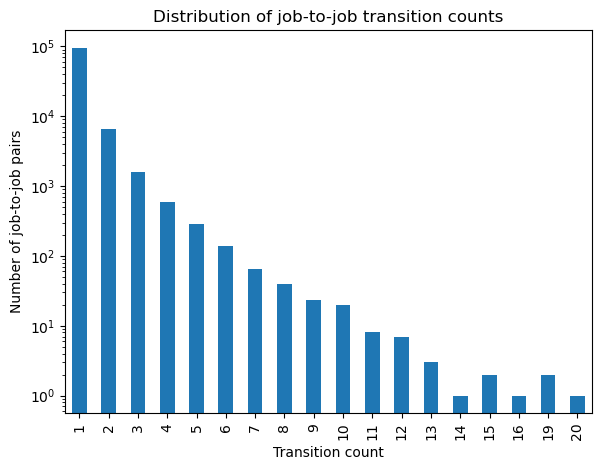

In [35]:
trans_df["count"].value_counts().sort_index().plot(kind="bar")
plt.xlabel("Transition count")
plt.ylabel("Number of job-to-job pairs")
plt.title("Distribution of job-to-job transition counts")
plt.tight_layout()
plt.yscale("log")
plt.show()

In [36]:
# normalize in conditional probabilities
# Knowing that the candidate is in job A, what is the probability that they will move to job B?

trans_df["prob"] = (
    trans_df["count"] /
    trans_df.groupby("from_job")["count"].transform("sum")
)

In [37]:
trans_df.head()

,from_job,to_job,count,prob
0,305,299,1,0.058824
1,299,300,1,0.066667
2,300,290,1,0.040000
3,290,282,1,0.100000
4,282,274,1,0.055556


In [38]:
trans_df.groupby("from_job")["prob"].sum().head()


from_job
0    1.0
1    1.0
2    1.0
3    1.0
5    1.0
Name: prob, dtype: float64

In [39]:
# create a fallback in case job_id is not in from_job : overall popularity of jobs

popular_jobs = (
    trans_df.groupby("to_job")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
    .tolist()
)

In [40]:
# implement top 10 from last job
# "If the last job viewed is X, recommend the 10 most likely jobs after X."

def recommend_next_jobs(last_job, trans_df, popular_jobs, k=10):
    candidates = trans_df[trans_df["from_job"] == last_job]
    
    if len(candidates) == 0:
        return popular_jobs[:k]
    
    return (
        candidates
        .sort_values("prob", ascending=False)
        .head(k)["to_job"]
        .tolist()
    )


In [41]:
example_job = trans_df["from_job"].iloc[0]
recommend_next_jobs(example_job, trans_df, popular_jobs)

[299, 2224, 1816, 3091, 4395, 301, 729, 799, 998, 306]

### 3. Evaluate the baseline model on validation set

In [42]:
# compute MRR@10 on validation

y_true = []
y_pred = []

for _, row in val_df.iterrows():
    last_job = row["full_job_sequence"][-2]          # last job seen
    true_job = row["full_job_sequence"][-1]              # target jon
    
    preds = recommend_next_jobs(
        last_job,
        trans_df,
        popular_jobs,
        k=10
    )
    
    y_true.append(true_job)
    y_pred.append(preds)


In [43]:
# saving baseline score

mrr = compute_mrr(y_true, y_pred, k=10)
print(f"MRR@10 (baseline Markov): {mrr:.4f}")

MRR@10 (baseline Markov): 0.3500


In [44]:
# analysing when true job is missing in top 10

miss_rate = sum(t not in p for t, p in zip(y_true, y_pred)) / len(y_true)
miss_rate

0.31633616619452315

In [45]:
# analysing rank when true job is in top 10

ranks = [p.index(t) + 1 for t, p in zip(y_true, y_pred) if t in p]
sum(ranks)/len(ranks), min(ranks), max(ranks)

(3.5755064456721914, 1, 10)

### 4. Session-aware recommender

In [46]:
# group all recommendations on the whole session

# create a dictionnary from_job -> list[(to_job, prob)]

next_map = defaultdict(list)
for r in trans_df.itertuples(index=False):
    next_map[r.from_job].append((r.to_job, r.prob))

In [47]:
def recommend_from_session(job_seq, next_map, popular_jobs, k=10):
    scores = defaultdict(float)

    for j in job_seq:
        for to_job, prob in next_map.get(j, []):
            scores[to_job] += prob

    # fallback if no signal
    if not scores:
        return popular_jobs[:k]

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [job for job, _ in ranked[:k]]


In [48]:
# add weighted score by recency

def recommend_from_session_recency(job_seq, next_map, popular_jobs, k=10):
    scores = defaultdict(float)
    L = len(job_seq)

    for i, j in enumerate(job_seq):
        weight = (i + 1) / L   # linear recency
        for to_job, prob in next_map.get(j, []):
            scores[to_job] += weight * prob

    if not scores:
        return popular_jobs[:k]

    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [job for job, _ in ranked[:k]]


In [49]:
# example on one session

seq = val_df.iloc[2]["full_job_sequence"]
history = seq[:-1]        # everything except the target
true_job = seq[-1]

preds_plain = recommend_from_session(history, next_map, popular_jobs)
preds_recent = recommend_from_session_recency(history, next_map, popular_jobs)

print("History:", history)
print("True job:", true_job)
print("Plain:", preds_plain)
print("Rank plain:", preds.index(true_job) + 1 if true_job in preds else "MISS")
print("Recency:", preds_recent)
print("Rank recency:", preds.index(true_job) + 1 if true_job in preds else "MISS")

History: [276, 272, 273, 270, 269, 230]
True job: 267
Plain: [505, 110, 255, 105, 5092, 273, 26, 509, 3210, 1222]
Rank plain: MISS
Recency: [505, 110, 5092, 285, 255, 3210, 1222, 263, 230, 1753]
Rank recency: MISS


In [50]:
# test differents k-values

k_values = [1, 3, 5, 7, 10]

def predict_last_k(seq, k):
    return seq[-k:] if len(seq) >= k else seq

results = {}

for k in k_values:
    y_true = []
    y_pred = []

    for _, row in val_df.iterrows():
        seq = row["full_job_sequence"]
        history = predict_last_k(seq[:-1], k)
        true_job = seq[-1]

        preds = recommend_from_session_recency(
            history,
            next_map,
            popular_jobs,
            k=10
        )

        y_true.append(true_job)
        y_pred.append(preds)

    mrr = compute_mrr(y_true, y_pred, k=10)
    results[k] = mrr
    print(f"k={k} → MRR@10 = {mrr:.4f}")


k=1 → MRR@10 = 0.3476
k=3 → MRR@10 = 0.3289
k=5 → MRR@10 = 0.3055
k=7 → MRR@10 = 0.2905
k=10 → MRR@10 = 0.2795


Performance decreases as k last jobs increases.
The best MRR@10 is obtained with **k = 1**, meaning the last visited job is the most informative.


This confirms that user intent shifts quickly and that older interactions add noise rather than signal.

# II. Action Prediction

### 1. Small EDA on number of 'views'

In [51]:
# inspect initial distribution

df["action"].value_counts(normalize=True)

action
view     0.604962
apply    0.395038
Name: proportion, dtype: float64

In [52]:
df["n_view"] = df["actions"].apply(
    lambda x: len(ast.literal_eval(x)) if isinstance(x, str) else len(x)
)

prop = (
    df.groupby("n_view")["action"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

prop.head()

action,apply,view
n_view,,
3,0.374314,0.625686
4,0.388075,0.611925
5,0.356808,0.643192
6,0.389001,0.610999
7,0.388114,0.611886


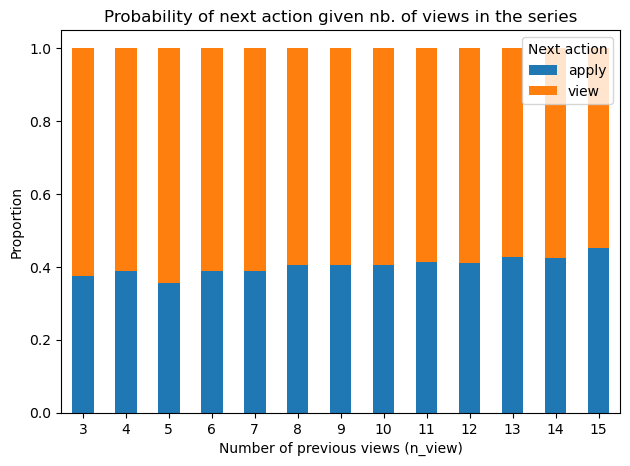

In [53]:
prop.plot(
    kind="bar",
    stacked=True
)

plt.xlabel("Number of previous views (n_view)")
plt.ylabel("Proportion")
plt.title("Probability of next action given nb. of views in the series")
plt.legend(title="Next action")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()


In [54]:
def trailing_views(actions):
    c = 0
    for a in reversed(actions):
        if a == "view":
            c += 1
        else:
            break
    return c

df["trail_view"] = df["actions"].apply(
    lambda x: trailing_views(ast.literal_eval(x)) if isinstance(x, str) else trailing_views(x)
)


prop2 = (
    df.groupby("trail_view")["action"]
      .value_counts(normalize=True)
      .unstack(fill_value=0)
)

prop2.head()


action,apply,view
trail_view,,
0,0.805334,0.194666
1,0.330948,0.669052
2,0.280347,0.719653
3,0.131668,0.868332
4,0.113126,0.886874


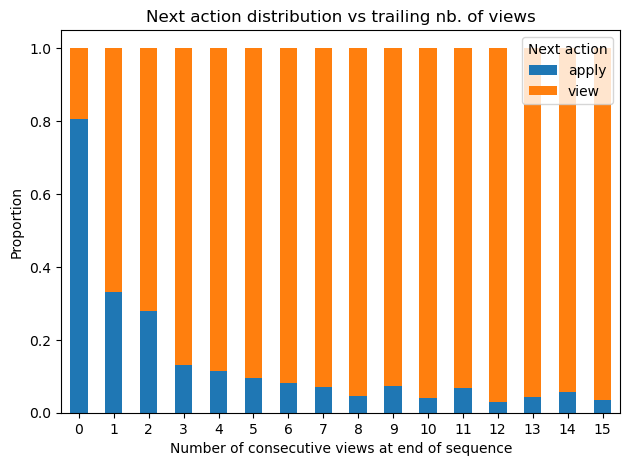

In [55]:
prop2.plot(kind="bar", stacked=True)

plt.xlabel("Number of consecutive views at end of sequence")
plt.ylabel("Proportion")
plt.title("Next action distribution vs trailing nb. of views")
plt.legend(title="Next action")
plt.tight_layout()
plt.xticks(rotation=0)
plt.show()

### 2. Linear regression using one feature: the number of trailing 'view' actions before the next action

In [56]:
# preparing data

action_df = df[["full_action_sequence"]].copy()

# history = all actions except the last one
action_df["action_history"] = action_df["full_action_sequence"].apply(lambda x: x[:-1])

# target = last action
action_df["action_target"] = action_df["full_action_sequence"].apply(lambda x: x[-1])


# feature engineering

def trailing_views(actions):
    c = 0
    for a in reversed(actions):
        if a == "view":
            c += 1
        else:
            break
    return c

action_df["trail_view"] = action_df["action_history"].apply(trailing_views)

In [57]:
# model training

X_action = action_df[["trail_view"]]
y_action = action_df["action_target"]

action_clf = LogisticRegression()
action_clf.fit(X_action, y_action)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


y_pred = action_clf.predict(X_val_ml)

print(classification_report(y_val_ml, y_pred))

bal_acc = balanced_accuracy_score(y_val_ml, y_pred)
print(f"Balanced accuracy: {bal_acc:.3f}")


- We train a simple logistic regression using one feature: the number of trailing 'view' actions.
- This feature is highly predictive of the next action.
- The model achieves 83% accuracy, far above the 60% baseline.
- It detects most 'apply' actions, with a recall of 87%.
- The more consecutive 'view' actions at the end of a session, the more likely the next action is to be 'apply'.


### 3. predict_action

In [58]:
def predict_action(actions):
    """
    actions: list[str] (history only)
    returns: "view" or "apply"
    """
    tv = trailing_views(actions)
    X = pd.DataFrame([[tv]], columns=["trail_view"])
    return action_clf.predict(X)[0]

# Final Prediction Function

In [117]:
def predict_session(job_ids, actions):
    """
    job_ids : list[int]
    actions : list[str]
    returns : (top10_jobs: list[int], action: str)
    """

    # Hybrid job recommendation
    top10_jobs = safe_recommend(job_ids, k=10)

    # Action prediction
    action = predict_action(actions)

    return top10_jobs, action


In [112]:
predictions = []

for _, row in X_test.iterrows():
    top10_jobs, action = predict_session(
        row["job_ids"],
        row["actions"]
    )

    predictions.append({
        "session_id": row["session_id"],
        "action": action,
        "job_id": top10_jobs
    })

submission_df = pd.DataFrame(predictions)

In [113]:
print(submission_df.shape)

# 10 jobs par ligne
print(submission_df["job_id"].apply(len).value_counts())

# distribution action
print(submission_df["action"].value_counts(normalize=True))

(1819, 3)
job_id
10    1819
Name: count, dtype: int64
action
view     0.518966
apply    0.481034
Name: proportion, dtype: float64


In [116]:
def safe_recommend(job_ids, k=10):
    recs = recommend_jobs(job_ids, k=k)

    if len(recs) < k:
        seen = set(job_ids) | set(recs)
        for j, _ in sorted(job_popularity.items(), key=lambda x: x[1], reverse=True):
            if j not in seen:
                recs.append(j)
            if len(recs) == k:
                break

    return recs


In [63]:
from_jobs = set(trans_df["from_job"].unique())

cold_rate = sum(
    row["job_ids"][-1] not in from_jobs
    for _, row in X_test.iterrows()
) / len(X_test)

cold_rate

0.07366684991753711

In [118]:
file_name = "submission_hybrid_v1.csv"

submission_df.to_csv(file_name, index=False)

print(f"Saved: {file_name}")


Saved: submission_hybrid_v1.csv


In [119]:
check_df = pd.read_csv(file_name)

print(check_df.shape)
print(check_df.head())

(1819, 3)
   session_id action                                             job_id
0           0   view  [1220, 1876, 360, 1293, 163, 363, 3784, 6006, ...
1           1  apply  [3191, 1382, 4228, 3849, 2455, 2801, 3953, 138...
2           2   view  [777, 1377, 3958, 2356, 1367, 878, 501, 934, 7...
3           3  apply  [4561, 2778, 10731, 19876, 4551, 762, 15600, 1...
4           4   view  [214, 1237, 445, 956, 95, 31, 2457, 688, 579, ...
